In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.0 MB/s eta 0:00:00


In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier

In [9]:
train_data = pd.read_csv('train_data.csv')
match_data = pd.read_csv('match_level_data.csv')
batsman_data = pd.read_csv('batsman_data.csv')
bowler_data = pd.read_csv('bowler_data.csv')

In [ ]:
match_data = pd.read_csv("OneDrive/match_level_scorecard.csv")
match_data.drop(columns=['season','team1', 'team2','city','umpire1', 'umpire2', 'series_type','venue','series_name','winner'], axis=1, inplace=True)
match_data.head()

,match id,by,win amount,toss winner,toss decision,match_dt,lighting,ground_id,inning1_runs,inning1_wickets,inning1_balls,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,winner_id,player_of_the_match_id
0,8638034,wickets,9.0,Wn,field,2021-01-01,night match,17681,148,6,130,152.0,1.0,97.0,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0...,18570,2653993.0:6718326.0:6718382.0:2486896.0:228878...,18570,NaN
1,8588005,runs,7.0,Sy Tr,field,2021-01-01,night match,6663,166,6,106,117.0,2.0,74.0,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1...,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652....,33963,1749075.0
2,8587837,wickets,4.0,Sy Ss,bat,2021-01-02,night match,1476,165,8,126,171.0,6.0,119.0,33956,7869987.0:7620283.0:2076192.0:4002340.0:306369...,33921,7620269.0:2286437.0:87191.0:5786766.0:3114803....,33921,3890984.0
3,8638041,wickets,2.0,Oo,field,2021-01-02,night match,17681,153,7,128,156.0,8.0,126.0,17982,7907451.0:4381761.0:31464.0:4949790.0:258649.0...,18360,2319638.0:256080.0:7918280.0:3913447.0:2690498...,18360,NaN
4,8587921,runs,21.0,Me Ss,field,2021-01-02,day/night match,6348,164,5,126,143.0,9.0,123.0,33928,4223883.0:2161599.0:1655436.0:5788418.0:319948...,33949,363047.0:2275097.0:3901078.0:2275195.0:4230127...,33928,3125849.0


In [ ]:
df = pd.DataFrame(match_data)
potm = df['player_of_the_match_id']
print(len(potm.unique()))

527


In [37]:
from sklearn.preprocessing import LabelEncoder
# Instantiate the encoder
label_encoder = LabelEncoder()

# Fit and transform the 'toss decision' column
match_data['toss decision'] = label_encoder.fit_transform(match_data['toss decision'])

# Map 'toss winner' column to the respective team IDs
match_data['toss winner'] = match_data.apply(
    lambda row: row['team1_id'] if row['toss winner'] == row['team1_id'] else row['team2_id'], axis=1)

# Fit and transform the 'toss decision' column
match_data['by'] = label_encoder.fit_transform(match_data['by'])

match_data['lighting'] = label_encoder.fit_transform(match_data['lighting'])
match_data.head(10)

,match id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,...,player_of_the_match_id,total_runs,team1_roster_list,team2_roster_list,team1_total_fours,team2_total_fours,team1_total_sixes,team2_total_sixes,team1_total_wickets_lost,team2_total_wickets_lost
0,8638034,Nn Ds,Wn,Wn,1,9,18570,1,By Ol,Mount Maunganui,...,NaN,150.0,"[7907451.0, 4381761.0, 31464.0, 258649.0, 4949...","[2653993.0, 6718326.0, 6718382.0, 2486896.0, 2...",136.0,494.0,59.0,172.0,81,174
1,8588005,Me Rs,Sy Tr,Sy Tr,0,7,33963,1,Ca Ol,Carrara,...,1749075.0,141.5,"[37351.0, 46794.0, 5406540.0, 2231928.0, 18140...","[1506098.0, 1749075.0, 36665.0, 2083409.0, 753...",321.0,478.0,148.0,195.0,179,189
2,8587837,Sy Ss,Be Ht,Be Ht,1,4,33921,0,Be Ct Gd,Brisbane,...,3890984.0,168.0,"[7869987.0, 7620283.0, 2076192.0, 4002340.0, 3...","[7620269.0, 2286437.0, 87191.0, 5786766.0, 311...",465.0,203.0,144.0,92.0,178,158
3,8638041,Nn Ds,Oo,Oo,1,2,18360,1,By Ol,Mount Maunganui,...,NaN,154.5,"[7907451.0, 4381761.0, 31464.0, 4949790.0, 258...","[2319638.0, 256080.0, 7918280.0, 3913447.0, 26...",136.0,169.0,59.0,67.0,81,100
4,8587921,Ht Hs,Me Ss,Ht Hs,0,21,33949,1,Be Ol,Hobart,...,3125849.0,153.5,"[4223883.0, 2161599.0, 1655436.0, 5788418.0, 3...","[363047.0, 2275097.0, 3901078.0, 2275195.0, 42...",463.0,442.0,222.0,283.0,211,216
5,8638048,Ad,Cy,Cy,1,10,17653,1,En Pk Or Ol,Auckland,...,NaN,53.5,"[5764576.0, 3069954.0, 3935854.0, 3913440.0, 4...","[4381747.0, 2659243.0, 3682160.0, 4381705.0, 3...",251.0,186.0,189.0,74.0,141,97
6,8587907,Ae Ss,Sy Ss,Sy Ss,1,7,33956,1,Ca Ol,Carrara,...,7869987.0,150.5,"[4685568.0, 5056134.0, 2285051.0, 1635773.0, 5...","[7869987.0, 7620283.0, 2076192.0, 4002340.0, 3...",381.0,463.0,119.0,144.0,180,178
7,8587984,Ph Ss,Me Rs,Ph Ss,0,96,33942,1,Ph Sm,Perth,...,4635658.0,137.0,"[2089079.0, 2827327.0, 4635658.0, 1626526.0, 1...","[5406540.0, 46794.0, 37351.0, 2669316.0, 18140...",752.0,302.0,379.0,140.0,249,164
8,8638055,Cl Ds,Nn Ds,Nn Ds,1,6,17982,1,Sn Pk,Hamilton,...,NaN,119.5,"[1945390.0, 6487032.0, 3083632.0, 6496118.0, 2...","[7907451.0, 4381761.0, 31464.0, 4949790.0, 258...",158.0,136.0,57.0,59.0,70,81
9,8588166,Me Ss,Ht Hs,Me Ss,0,10,33928,1,Be Ol,Hobart,...,2275097.0,178.0,"[363047.0, 2275097.0, 3737103.0, 2275195.0, 42...","[4223883.0, 2161599.0, 1655436.0, 319948.0, 62...",452.0,463.0,269.0,222.0,208,211


In [ ]:
#top_player = player_of_the_match_id.groupby('batsman_id')['runs'].sum().sort_values(ascending=False).head(10)

In [ ]:
match_data.shape

(1689, 20)

In [ ]:
bowler_data = pd.read_csv("OneDrive/bowler_level_scorecard.csv")
bowler_data.drop(columns=['bowler','bowler_details','match_dt','is_bowler_captain','is_bowler_keeper'],axis=1,inplace=True)
bowler_data.head()

,match id,bowler_id,inning,runs,wicket_count,balls_bowled,economy,maiden,dots,Fours,Sixes,wides,noballs
0,8638034,6718396.0,1,21,0,12,10.50,0,3.0,1,1,3,1
1,8638034,1585464.0,1,34,1,24,8.50,0,7.0,3,1,2,0
2,8638034,2486896.0,1,23,2,24,5.75,0,12.0,1,1,0,0
3,8638034,3083667.0,1,31,1,24,7.75,0,9.0,4,0,2,0
4,8638034,4950294.0,1,21,1,24,5.25,0,8.0,0,0,1,0


In [39]:

batsman_data.drop(columns=['batsman','batsman_details','match_dt','is_batsman_captain','is_batsman_keeper','out_by_fielder','out_by_bowler','is_bowler_captain','is_bowler_keeper'],axis=1,inplace=True)
batsman_data['Fours'].fillna(0, inplace=True)
batsman_data['Sixes'].fillna(0, inplace=True)
batsman_data['wicket kind'] = label_encoder.fit_transform(batsman_data['wicket kind'])
batsman_data['bowler_id'].fillna(0, inplace=True)
batsman_data.head(10)

,match id,batsman_id,inning,runs,balls_faced,over_faced_first,wicket kind,bowler_id,bowler_details,strike_rate,Fours,Sixes
0,8638034,7907451,1,7,5,1.1,1,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,140.00,1.0,0.0
1,8638034,4381761,1,46,46,1.2,1,6718382.0,NZ:Left-hand bat:Slow left-arm orthodox:,100.00,4.0,1.0
2,8638034,4949790,1,9,10,12.1,1,4950294.0,NZ:Right-hand bat:Legbreak googly:,90.00,0.0,0.0
3,8638034,3834305,1,28,22,13.6,1,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,127.27,3.0,0.0
4,8638034,3776849,1,18,13,17.2,9,0.0,NaN,138.46,0.0,1.0
5,8638034,6718340,1,1,2,20.3,9,0.0,NaN,50.00,0.0,0.0
6,8638034,31464,1,8,11,5.1,1,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,72.73,1.0,0.0
7,8638034,258649,1,19,12,8.1,1,3083667.0,NED:Right-hand bat:Right-arm medium-fast:,158.33,2.0,1.0
8,8638034,2653993,2,13,15,1.1,1,3776849.0,NZ:Right-hand bat:Right-arm fast-medium:,86.67,1.0,0.0
9,8638034,6718326,2,91,50,1.2,9,0.0,NaN,182.00,7.0,5.0


In [ ]:
batsman_data.shape

(24483, 12)

In [ ]:
train_data = pd.read_csv("OneDrive/train_data_with_samplefeatures.csv")
train_data.drop(columns=['winner','city','series_name','match_dt','venue','season'],axis=1,inplace=True)

train_data['lighting'] = label_encoder.fit_transform(train_data['lighting'])

#train_data['toss winner'] = match_data.apply(
 #   lambda row: row['team1_id'] if row['toss winner'] == row['team1_id'] else row['team2_id'], axis=1)
#train_data.head()
#label_encoder = LabelEncoder()
#train_data['team1'] = train_data['team1_id']
#train_data['team2'] = train_data['team2_id']
train_data['toss decision'] = label_encoder.fit_transform(train_data['toss decision'])
train_data['toss winner'] = train_data.apply(
    lambda row: row['team1_id'] if row['toss winner'] == row['team1'] else row['team2_id'],
    axis=1
)
train_data.drop(columns=['team1','team2'],axis=1,inplace=True)

train_data.head()

,match id,team1_id,team1_roster_ids,team2_id,team2_roster_ids,winner_id,toss winner,toss decision,lighting,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9331181,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,12634,12634,1,1,7398,1.666667,0.672131,139.000000,100.0,157.178571
1,8797060,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,20,41,1,1,1406,1.285714,1.952381,156.000000,50.0,103.500000
2,9433269,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,10576,8987,1,1,251,0.857143,0.672131,173.266667,0.0,154.333333
3,9587073,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,36084,36084,0,0,14300,2.166667,1.975610,164.266667,50.0,144.250000
4,9516457,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,48341,48341,1,2,7118,0.818182,1.327869,164.666667,0.0,189.000000


In [40]:
test_data.drop(columns=['team1','team2','team1_roster_ids','team2_roster_ids','city','match_dt','series_name','venue','season'],axis=1,inplace=True)
test_data['lighting'] = label_encoder.fit_transform(test_data['lighting'])

test_data['toss winner'] = test_data.apply(
    lambda row: row['team1_id'] if row['toss winner'] == row['team1_id'] else row['team2_id'], axis=1)

label_encoder = LabelEncoder()

test_data['toss decision'] = label_encoder.fit_transform(test_data['toss decision'])
test_data.head()

,match id,team1_id,team2_id,toss winner,toss decision,lighting,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,wickets_lost_ratio_last_15,avg_economy_ratio,avg_wicket_ratio
0,9250275,28594,90,90,1,0,3226,0.000000,0.019608,NaN,0.00,NaN,0.294118,1.003579,1.757848
1,9262189,36084,36098,36098,1,2,13915,0.615385,0.344262,151.285714,66.67,153.500,1.122596,0.969958,0.641467
2,9128776,30428,48334,48334,0,2,2764,0.842105,0.753086,171.066667,100.00,179.625,0.857958,1.026959,1.084605
3,9586919,36098,36112,36112,1,2,11892,0.285714,1.487805,166.000000,75.00,155.500,1.065301,1.047713,1.317065
4,9128538,30414,48341,48341,1,2,18752,2.375000,0.310330,169.933333,0.00,164.125,0.973832,1.270248,0.753147


In [ ]:
print(match_data.isnull().sum())

match id                    0
by                          0
win amount                  0
toss winner                 0
toss decision               0
match_dt                    0
lighting                    0
ground_id                   0
inning1_runs                0
inning1_wickets             0
inning1_balls               0
inning2_runs                0
inning2_wickets             0
inning2_balls               0
team1_id                    0
team1_roster_ids            0
team2_id                    0
team2_roster_ids            0
winner_id                   0
player_of_the_match_id    514
dtype: int64


In [ ]:
print(bowler_data.isnull().sum())

match id        0
bowler_id       0
inning          0
runs            0
wicket_count    0
balls_bowled    0
economy         0
maiden          0
dots            0
Fours           0
Sixes           0
wides           0
noballs         0
dtype: int64


In [ ]:
print(batsman_data.isnull().sum())

match id               0
batsman_id             0
inning                 0
runs                   0
balls_faced            0
over_faced_first       0
wicket kind            0
bowler_id              0
bowler_details      6355
strike_rate            9
Fours                  0
Sixes                  0
dtype: int64


In [ ]:
print(train_data.isnull().sum())
train_data.shape

match id                      0
team1_id                      0
team1_roster_ids              0
team2_id                      0
team2_roster_ids              0
winner_id                     0
toss winner                   0
toss decision                 0
lighting                      0
ground_id                     0
team_count_50runs_last15      0
team_winp_last5               0
team1only_avg_runs_last15    21
team1_winp_team2_last15       0
ground_avg_runs_last15       53
dtype: int64


(948, 15)

In [ ]:
print(test_data.isnull().sum())

match id                      0
team1_id                      0
team2_id                      0
toss winner                   0
toss decision                 0
lighting                      0
ground_id                     0
team_count_50runs_last15      0
team_winp_last5               0
team1only_avg_runs_last15     7
team1_winp_team2_last15       0
ground_avg_runs_last15       10
dtype: int64


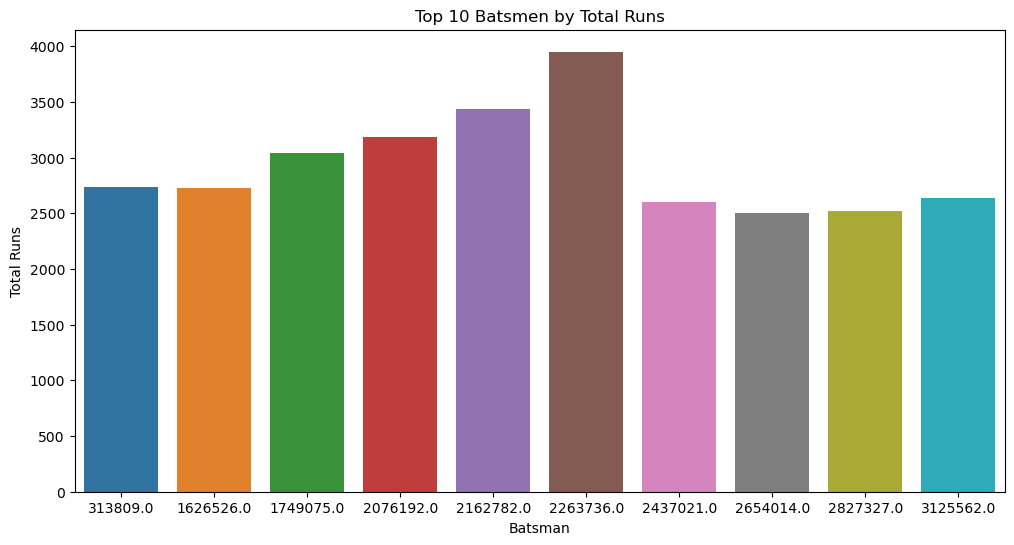

In [ ]:
top_batsmen = batsman_data.groupby('batsman_id')['runs'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_batsmen.index, y=top_batsmen.values)
plt.title('Top 10 Batsmen by Total Runs')
plt.xlabel('Batsman')
plt.ylabel('Total Runs')
plt.show()

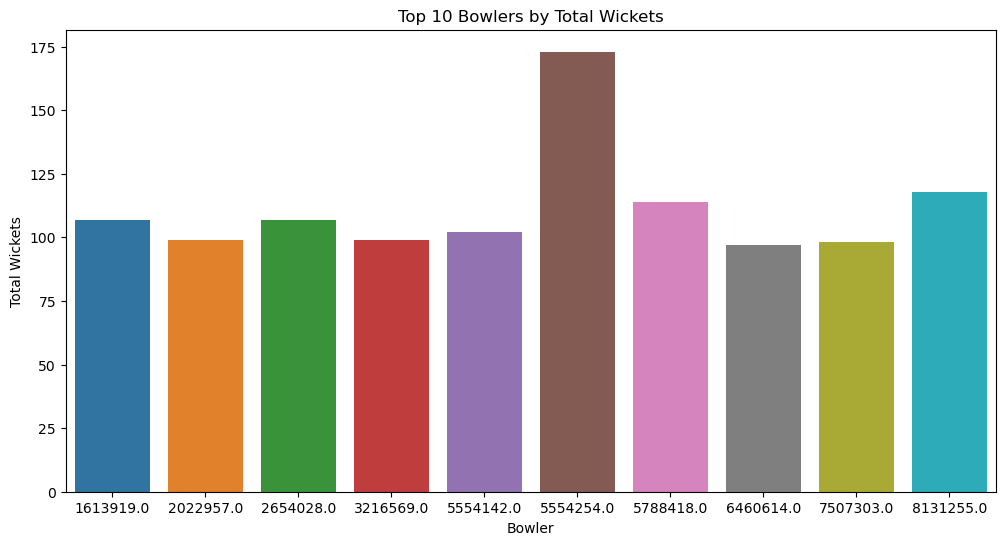

In [ ]:
top_bowlers = bowler_data.groupby('bowler_id')['wicket_count'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_bowlers.index, y=top_bowlers.values)
plt.title('Top 10 Bowlers by Total Wickets')
plt.xlabel('Bowler')
plt.ylabel('Total Wickets')
plt.show()

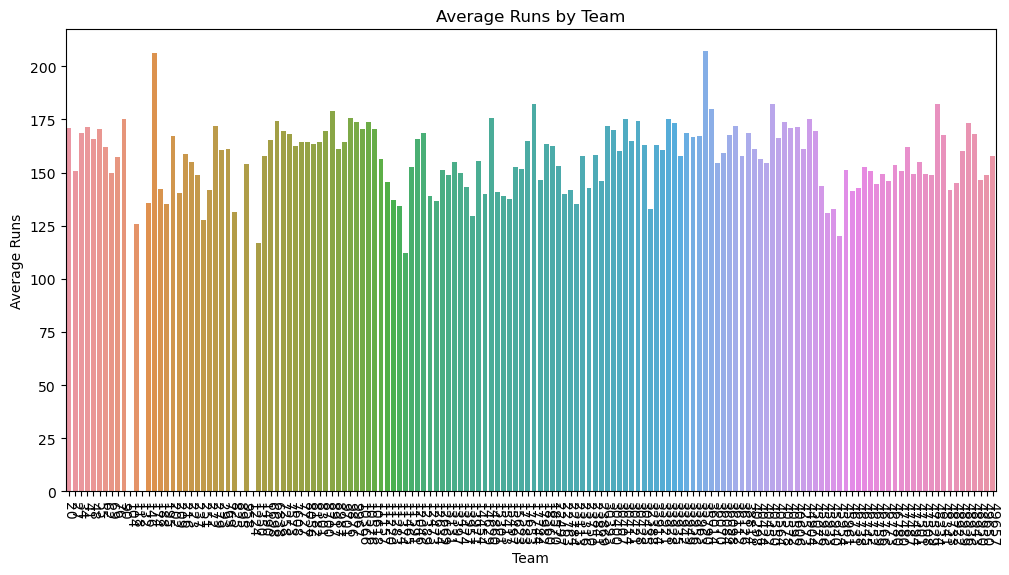

In [ ]:
avg_runs_team = train_data.groupby('team1_id')['team1only_avg_runs_last15'].mean()
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_runs_team.index, y=avg_runs_team.values)
plt.title('Average Runs by Team')
plt.xlabel('Team')
plt.ylabel('Average Runs')
plt.xticks(rotation=-90)
plt.show()

In [ ]:
df = pd.DataFrame(train_data)
team1 = df['team1_id']
team2 = df['team2_id']
all_teams = pd.concat([team1, team2])

unique_teams = all_teams.unique()

total_teams = len(unique_teams)
print(len(unique_teams))

162


In [ ]:
train_data.shape
train_data.head()

,match id,team1_id,team1_roster_ids,team2_id,team2_roster_ids,winner_id,toss winner,toss decision,lighting,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9331181,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,12634,12634,1,1,7398,1.666667,0.672131,139.000000,100.0,157.178571
1,8797060,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,20,41,1,1,1406,1.285714,1.952381,156.000000,50.0,103.500000
2,9433269,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,10576,8987,1,1,251,0.857143,0.672131,173.266667,0.0,154.333333
3,9587073,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,36084,36084,0,0,14300,2.166667,1.975610,164.266667,50.0,144.250000
4,9516457,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,48341,48341,1,2,7118,0.818182,1.327869,164.666667,0.0,189.000000


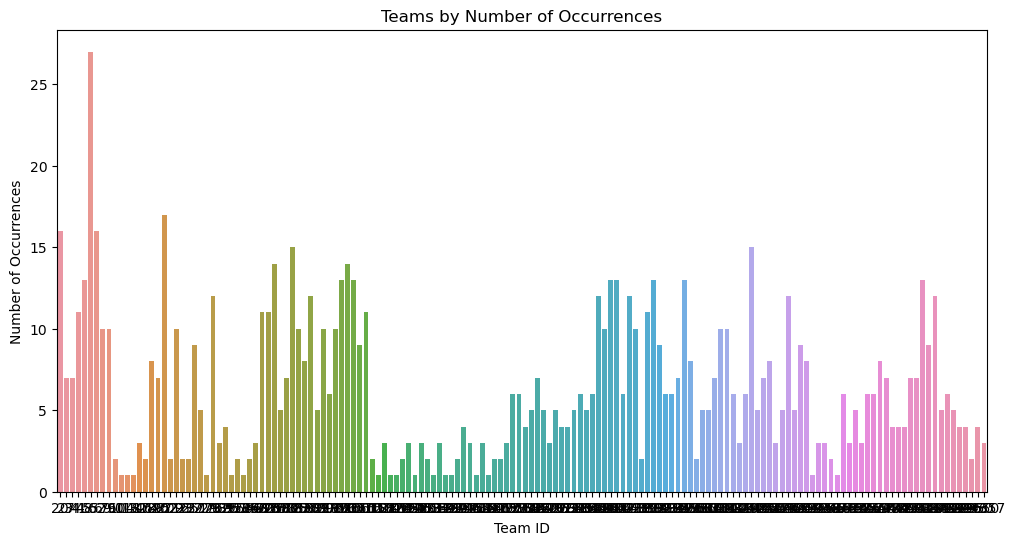

In [ ]:

# Extract the 'team1_id' column and create a DataFrame
data1 = train_data['team1_id']
data2 = train_data['team2_id']
pd.concat([data1,data2],ignore_index = True)
df = pd.DataFrame(data1)

# Calculate value counts
value_counts = df['team1_id'].value_counts()

# Convert value counts to a DataFrame and rename columns
counts_df = value_counts.reset_index()
counts_df.columns = ['team_id', 'count']

# Select the top 10 teams
top_teams = counts_df.head(162)

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x=top_teams['team_id'], y=top_teams['count'])
plt.xlabel('Team ID')
plt.ylabel('Number of Occurrences')
plt.title('Teams by Number of Occurrences')
plt.show()



In [ ]:
df = pd.DataFrame(train_data)
grounds = df['ground_id']
num = grounds.unique()
print(len(num))

123


In [ ]:
train_data.head()

,match id,team1_id,team1_roster_ids,team2_id,team2_roster_ids,winner_id,toss winner,toss decision,lighting,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9331181,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,12634,12634,1,1,7398,1.666667,0.672131,139.000000,100.0,157.178571
1,8797060,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,20,41,1,1,1406,1.285714,1.952381,156.000000,50.0,103.500000
2,9433269,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,10576,8987,1,1,251,0.857143,0.672131,173.266667,0.0,154.333333
3,9587073,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,36084,36084,0,0,14300,2.166667,1.975610,164.266667,50.0,144.250000
4,9516457,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,48341,48341,1,2,7118,0.818182,1.327869,164.666667,0.0,189.000000


In [ ]:
match_data.groupby(['ground_id']).count()['inning1_runs']

ground_id
83       19
251      29
328      26
342      18
440      25
538      23
664      19
769      10
783       2
797      15
825      13
930      23
937      17
1042     19
1161     38
1224     24
1231      4
1245     15
1266     25
1378     21
1406     11
1469      4
1476     15
1511      2
1525     13
1637     18
1658      2
1672      7
1833     14
1840      5
1994      4
2050     15
2057     20
2127     22
2190     10
2239     17
2344     26
2764     12
2932      1
3128      2
3135      6
3184      4
3226      4
3422     36
3541      7
3569      9
3618      5
3702      8
3828     27
3961      7
4045     41
4304      2
4416      1
4521     25
4661     17
4794      4
4815      4
4913     11
5004     39
5081     11
5312     13
5382      1
5396      9
5893     24
5949     24
6327      9
6348     15
6579      1
6663      6
6831      4
6950      8
7020      7
7041     46
7118     12
7230      3
7286     17
7307      3
7398     18
7475      1
7930      6
8175      3
8252     19
8301  

In [ ]:
match_data[match_data['ground_id'] == 7041].groupby(match_data['ground_id'] == 7041)['inning1_runs'].mean()

ground_id
True    144.891304
Name: inning1_runs, dtype: float64

In [10]:
# Calculate average runs scored in each ground
match_data['total_runs'] = (match_data['inning1_runs'] + match_data['inning2_runs'])*0.5
ground_avg_runs = match_data.groupby('ground_id')['total_runs'].mean().reset_index()
ground_avg_runs.columns = ['ground_id', 'avg_runs']

print(ground_avg_runs)


     ground_id    avg_runs
0           83  148.026316
1          251  155.448276
2          328  152.653846
3          342  163.222222
4          440  153.860000
..         ...         ...
146      24828  182.500000
147      24877  140.045455
148      25038  151.750000
149      25045  132.857143
150      25479  102.500000

[151 rows x 2 columns]


In [11]:
# Merge the average runs data into the main dataframe
train_data = train_data.merge(ground_avg_runs, on='ground_id', how='left')
# Replace the null values
train_data['ground_avg_runs_last15'].fillna(train_data['avg_runs'], inplace=True)

# Drop the avg_runs column as it is no longer needed
train_data.drop(columns=['avg_runs'], inplace=True)

train_data.head(20)


,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,Hl Ph,12634,Hl Ph,...,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.000000,100.00,157.178571
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,Ed,20,Wt Is,...,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.000000,50.00,103.500000
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,We,10576,Ne,...,2023-06-02,day/night match,Vy Bt,2023,251,0.857143,0.672131,173.266667,0.00,154.333333
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,Ga An Ws,36084,Ga An Ws,...,2023-09-10,day match,Cn Pr Le,2023,14300,2.166667,1.975610,164.266667,50.00,144.250000
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,Gt Ts,48341,Gt Ts,...,2023-04-13,night match,In Pr Le,2023,7118,0.818182,1.327869,164.666667,0.00,189.000000
5,9457412,Ka Ts,42573,393371.0:1594347.0:9470873.0:7960847.0:4403426...,Cm Cs,40424,7864009.0:4502392.0:6551978.0:2820957.0:280412...,Cm Cs,40424,Cm Cs,...,2023-01-09,night match,Bh Pr Le,2022/23,14188,1.000000,1.000000,158.444444,50.00,147.933333
6,9292548,Aa,27,7537004.0:37351.0:1870357.0:2275195.0:4635658....,Ia,55,2954769.0:238727.0:1776627.0:3125562.0:4377610...,Ia,55,Ia,...,2022-09-25,night match,Aa tr of Ia,2022,13880,0.700000,1.487805,141.400000,50.00,181.625000
7,9271758,Ja Ks,47501,6818622.0:5490596.0:6551978.0:4403545.0:298612...,Ge Gs,47494,6517118.0:4403531.0:4932864.0:2214792.0:752034...,Ja Ks,47501,Ja Ks,...,2022-12-18,day match,La Pr Le,2022/23,7041,0.909091,1.487805,156.153846,40.00,129.933333
8,9331048,Hl Ph,12634,3500958.0:4231751.0:2735081.0:3698337.0:505819...,Sa,14860,9098571.0:227793.0:5977026.0:8442244.0:1663885...,Hl Ph,12634,Sa,...,2022-10-18,day/night match,Sd Mq Ai Ty,2022/23,7398,0.272727,0.506173,138.500000,0.00,157.692308
9,9123162,Id,216,2124002.0:2123974.0:7695666.0:6729862.0:649641...,Ia,55,3479860.0:5043310.0:3125562.0:4377610.0:210328...,Ia,55,Ia,...,2022-06-26,day match,Ia tr of Id,2022,6831,0.347826,0.506173,154.266667,0.00,148.500000


In [ ]:
row_index = df.loc[df['ground_id'] == 13880].index
row_index


Int64Index([6, 128, 260, 438], dtype='int64')

In [ ]:
train_data.iloc[6]

match id                                                               9292548
team1_id                                                                    27
team1_roster_ids             7537004.0:37351.0:1870357.0:2275195.0:4635658....
team2_id                                                                    55
team2_roster_ids             2954769.0:238727.0:1776627.0:3125562.0:4377610...
winner_id                                                                   55
toss winner                                                                 55
toss decision                                                                1
lighting                                                                     2
ground_id                                                                13880
team_count_50runs_last15                                                   0.7
team_winp_last5                                                       1.487805
team1only_avg_runs_last15                           

In [12]:
# Step 1: Determine which innings team1 played in and calculate the average runs
def calculate_avg_runs_last15(df):
    df = df.sort_values('match id', ascending=False).head(15)
    df['team1_inning_runs'] = np.where(df['team1_id'] == df['toss winner'],
                                       np.where(df['toss decision'] == 1, df['inning1_runs'], df['inning2_runs']),
                                       np.where(df['toss decision'] == 1, df['inning2_runs'], df['inning1_runs']))
    return df['team1_inning_runs'].mean()

team_avg_runs = (
    match_data
    .groupby('team1_id')
    .apply(calculate_avg_runs_last15)
    .reset_index(name='avg_runs_last15')
)

# Step 2: Fill the null values in the train_data team1only_avg_runs_last15 column with these calculated averages
train_data = train_data.merge(team_avg_runs, how='left', left_on='team1_id', right_on='team1_id')
train_data['team1only_avg_runs_last15'].fillna(train_data['avg_runs_last15'], inplace=True)
train_data.drop(columns=['avg_runs_last15'], inplace=True)

train_data.head()


,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,Hl Ph,12634,Hl Ph,...,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.000000,100.0,157.178571
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,Ed,20,Wt Is,...,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.000000,50.0,103.500000
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,We,10576,Ne,...,2023-06-02,day/night match,Vy Bt,2023,251,0.857143,0.672131,173.266667,0.0,154.333333
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,Ga An Ws,36084,Ga An Ws,...,2023-09-10,day match,Cn Pr Le,2023,14300,2.166667,1.975610,164.266667,50.0,144.250000
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,Gt Ts,48341,Gt Ts,...,2023-04-13,night match,In Pr Le,2023,7118,0.818182,1.327869,164.666667,0.0,189.000000


In [13]:
import pandas as pd

def calculate_avg_runs_on_ground(match_data, data_to_update, team_col='team', ground_col='ground_id', runs_col1='inning1_runs', runs_col2='inning2_runs', winner_col='winner_id'):
    # Step 1: Extract relevant columns and create a new DataFrame for average runs calculation
    avg_runs_data = match_data[[team_col + '1_id', team_col + '2_id', winner_col, ground_col, runs_col1, runs_col2]].copy()

    # Step 2: Initialize dictionaries to store average runs by team and ground
    team1_avg_runs = {}
    team2_avg_runs = {}

    # Step 3: Calculate average runs for team1 and team2 on each ground
    for index, row in avg_runs_data.iterrows():
        ground_id = row[ground_col]
        team1_id = row[team_col + '1_id']
        team2_id = row[team_col + '2_id']
        inning1_runs = row[runs_col1]
        inning2_runs = row[runs_col2]

        if row[winner_col] == team1_id:
            if ground_id not in team1_avg_runs:
                team1_avg_runs[ground_id] = []
            team1_avg_runs[ground_id].append(inning1_runs)

            if ground_id not in team2_avg_runs:
                team2_avg_runs[ground_id] = []
            team2_avg_runs[ground_id].append(inning2_runs)

        elif row[winner_col] == team2_id:
            if ground_id not in team1_avg_runs:
                team1_avg_runs[ground_id] = []
            team1_avg_runs[ground_id].append(inning2_runs)

            if ground_id not in team2_avg_runs:
                team2_avg_runs[ground_id] = []
            team2_avg_runs[ground_id].append(inning1_runs)

    # Step 4: Calculate average runs for each team on each ground
    team1_avg_runs_final = {ground_id: sum(runs) / len(runs) for ground_id, runs in team1_avg_runs.items()}
    team2_avg_runs_final = {ground_id: sum(runs) / len(runs) for ground_id, runs in team2_avg_runs.items()}

    # Step 5: Merge the average runs data with data_to_update
    data_to_update[team_col + '1_avg_runs_on_' + ground_col] = data_to_update[ground_col].map(team1_avg_runs_final)
    data_to_update[team_col + '2_avg_runs_on_' + ground_col] = data_to_update[ground_col].map(team2_avg_runs_final)

    return data_to_update


In [14]:
# Example call for train_data
train_data = calculate_avg_runs_on_ground(match_data, train_data, team_col='team', ground_col='ground_id', runs_col1='inning1_runs', runs_col2='inning2_runs', winner_col='winner_id')

# Display the updated DataFrame
train_data.head()


,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team1_avg_runs_on_ground_id,team2_avg_runs_on_ground_id
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,Hl Ph,12634,Hl Ph,...,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.000000,100.0,157.178571,158.777778,142.388889
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,Ed,20,Wt Is,...,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.000000,50.0,103.500000,178.636364,143.727273
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,We,10576,Ne,...,Vy Bt,2023,251,0.857143,0.672131,173.266667,0.0,154.333333,164.344828,146.551724
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,Ga An Ws,36084,Ga An Ws,...,Cn Pr Le,2023,14300,2.166667,1.975610,164.266667,50.0,144.250000,158.111111,140.888889
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,Gt Ts,48341,Gt Ts,...,In Pr Le,2023,7118,0.818182,1.327869,164.666667,0.0,189.000000,179.000000,164.916667


In [ ]:
train_data.shape

(948, 17)

In [15]:
import pandas as pd

def add_avg_strike_rate_ratio_feature(match_data, batsman_data, dataset):
    # Step 1: Parse the roster IDs into individual player IDs for both team1 and team2
    match_data['team1_roster_list'] = match_data['team1_roster_ids'].str.split(':')
    match_data['team2_roster_list'] = match_data['team2_roster_ids'].str.split(':')

    # Step 2: Function to calculate average strike rate for a team
    def calculate_team_strike_rate(roster_list, batsman_data):
        strike_rates = []
        for player_id in roster_list:
            try:
                player_id = float(player_id)  # Convert to float if necessary
                if player_id in batsman_data['batsman_id'].values:
                    strike_rate = batsman_data[batsman_data['batsman_id'] == player_id]['strike_rate'].values[0]
                    strike_rates.append(strike_rate)
            except ValueError:
                print(f"Invalid player ID: {player_id}")

        if len(strike_rates) > 0:
            return sum(strike_rates) / len(strike_rates)
        else:
            return 0  # Return 0 if no batsmen are found

    # Step 3: Sort match_data by match_dt in descending order
    match_data = match_data.sort_values(by='match_dt', ascending=False)

    # Step 4: Calculate average strike rate for the last 15 matches for each team
    teams = pd.concat([match_data['team1_id'], match_data['team2_id']]).unique()
    team_avg_strike_rates = {}

    for team_id in teams:
        team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)].head(15)
        team_roster = team_matches.apply(lambda x: x['team1_roster_list'] if x['team1_id'] == team_id else x['team2_roster_list'], axis=1)
        team_strike_rates = team_roster.apply(lambda x: calculate_team_strike_rate(x, batsman_data))
        team_avg_strike_rates[team_id] = team_strike_rates.mean()

    # Step 5: Calculate the ratio of average strike rates for each match in dataset
    dataset['team1_avg_strike_rate'] = dataset['team1_id'].map(team_avg_strike_rates)
    dataset['team2_avg_strike_rate'] = dataset['team2_id'].map(team_avg_strike_rates)
    dataset['avg_strike_rate_ratio'] = dataset.apply(
        lambda row: row['team1_avg_strike_rate'] / row['team2_avg_strike_rate'] if row['team2_avg_strike_rate'] != 0 else 1,
        axis=1
    )

    dataset.drop(columns=['team1_avg_strike_rate', 'team2_avg_strike_rate'], inplace=True)

    return dataset


In [16]:

# Example usage:
# Assuming match_data, batsman_data, and train_data are already defined
train_data = add_avg_strike_rate_ratio_feature(match_data, batsman_data, train_data)
# Display the updated train_data DataFrame with the new column
train_data.head()


,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team1_avg_runs_on_ground_id,team2_avg_runs_on_ground_id,avg_strike_rate_ratio
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,Hl Ph,12634,Hl Ph,...,2022/23,7398,1.666667,0.672131,139.000000,100.0,157.178571,158.777778,142.388889,1.532148
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,Ed,20,Wt Is,...,2021/22,1406,1.285714,1.952381,156.000000,50.0,103.500000,178.636364,143.727273,0.800575
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,We,10576,Ne,...,2023,251,0.857143,0.672131,173.266667,0.0,154.333333,164.344828,146.551724,0.666431
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,Ga An Ws,36084,Ga An Ws,...,2023,14300,2.166667,1.975610,164.266667,50.0,144.250000,158.111111,140.888889,0.933639
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,Gt Ts,48341,Gt Ts,...,2023,7118,0.818182,1.327869,164.666667,0.0,189.000000,179.000000,164.916667,1.256099


In [17]:
import pandas as pd

def calculate_economy_ratio(match_data, bowler_data, test_data):
    # Step 1: Parse the roster IDs into individual player IDs for both team1 and team2
    match_data['team1_roster_list'] = match_data['team1_roster_ids'].str.split(':')
    match_data['team2_roster_list'] = match_data['team2_roster_ids'].str.split(':')

    # Step 2: Function to calculate average economy for a team
    def calculate_team_economy(roster_list, bowler_data):
        economies = []
        for player_id in roster_list:
            player_id = float(player_id)  # Convert to float if necessary
            if player_id in bowler_data['bowler_id'].values:
                economy = bowler_data[bowler_data['bowler_id'] == player_id]['economy'].values[0]
                economies.append(economy)

        if len(economies) > 0:
            return sum(economies) / len(economies)
        else:
            return None

    # Step 3: Sort match_data by match_dt in descending order
    match_data = match_data.sort_values(by='match_dt', ascending=False)

    # Step 4: Calculate average economy for the last 15 matches for each team
    teams = pd.concat([match_data['team1_id'], match_data['team2_id']]).unique()
    team_avg_economy = {}

    for team_id in teams:
        team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)].head(15)
        team_roster = team_matches.apply(lambda x: x['team1_roster_list'] if x['team1_id'] == team_id else x['team2_roster_list'], axis=1)
        team_economies = team_roster.apply(lambda x: calculate_team_economy(x, bowler_data))
        team_avg_economy[team_id] = team_economies.mean()

    # Step 5: Calculate the ratio of average economies for each match in test_data
    test_data['team1_avg_economy'] = test_data['team1_id'].map(team_avg_economy)
    test_data['team2_avg_economy'] = test_data['team2_id'].map(team_avg_economy)
    test_data['avg_economy_ratio'] = test_data.apply(
        lambda row: row['team1_avg_economy'] / row['team2_avg_economy'] if row['team2_avg_economy'] and row['team1_avg_economy'] else 0,
        axis=1
    )

    test_data.drop(columns=['team1_avg_economy', 'team2_avg_economy'], inplace=True)

    return test_data


In [18]:
train_data = calculate_economy_ratio(match_data, bowler_data, train_data)
train_data.head()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team1_avg_runs_on_ground_id,team2_avg_runs_on_ground_id,avg_strike_rate_ratio,avg_economy_ratio
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,Hl Ph,12634,Hl Ph,...,7398,1.666667,0.672131,139.000000,100.0,157.178571,158.777778,142.388889,1.532148,1.185952
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,Ed,20,Wt Is,...,1406,1.285714,1.952381,156.000000,50.0,103.500000,178.636364,143.727273,0.800575,1.110736
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,We,10576,Ne,...,251,0.857143,0.672131,173.266667,0.0,154.333333,164.344828,146.551724,0.666431,0.880900
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,Ga An Ws,36084,Ga An Ws,...,14300,2.166667,1.975610,164.266667,50.0,144.250000,158.111111,140.888889,0.933639,1.050725
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,Gt Ts,48341,Gt Ts,...,7118,0.818182,1.327869,164.666667,0.0,189.000000,179.000000,164.916667,1.256099,1.142877


In [ ]:
train_data.shape

(948, 19)

In [19]:
import pandas as pd

def add_ratio_avg_dots_feature(match_data, bowler_data, dataset):
    # Step 1: Parse the roster IDs into individual player IDs for both team1 and team2
    match_data['team1_roster_list'] = match_data['team1_roster_ids'].str.split(':')
    match_data['team2_roster_list'] = match_data['team2_roster_ids'].str.split(':')

    # Step 2: Function to calculate average dot balls for a team
    def calculate_team_dots(roster_list, bowler_data):
        dotballs = []
        for player_id in roster_list:
            try:
                player_id = float(player_id)  # Convert to float if necessary
                if player_id in bowler_data['bowler_id'].values:
                    dots = bowler_data[bowler_data['bowler_id'] == player_id]['dots'].values[0]
                    dotballs.append(dots)
            except ValueError:
                print(f"Invalid player ID: {player_id}")

        if len(dotballs) > 0:
            return sum(dotballs) / len(dotballs)
        else:
            return 0  # Return 0 if no bowlers are found

    # Step 3: Calculate average dot balls for each team
    match_data = match_data.sort_values(by='match_dt', ascending=False)
    teams = pd.concat([match_data['team1_id'], match_data['team2_id']]).unique()
    team_avg_dots = {}
    for team_id in teams:
        team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)]
        team_roster = team_matches.apply(lambda x: x['team1_roster_list'] if x['team1_id'] == team_id else x['team2_roster_list'], axis=1)
        team_dotballs = team_roster.apply(lambda x: calculate_team_dots(x, bowler_data))
        team_avg_dots[team_id] = team_dotballs.mean()

    # Step 4: Calculate the ratio of average dot balls for each match in the dataset
    dataset['team1_avg_dots'] = dataset['team1_id'].map(team_avg_dots)
    dataset['team2_avg_dots'] = dataset['team2_id'].map(team_avg_dots)
    dataset['ratio_avg_dots'] = dataset.apply(
        lambda row: row['team1_avg_dots'] / row['team2_avg_dots'] if row['team2_avg_dots'] != 0 else 1,
        axis=1
    )

    # Adding team1_avg_dots/team2_avg_dots column
    dataset['ratio_avg_dots'] = dataset['team1_avg_dots'] / dataset['team2_avg_dots']

    dataset.drop(columns=['team1_avg_dots', 'team2_avg_dots'], inplace=True)
    return dataset


In [20]:
def add_win_percentage_ratio_feature(match_data, train_data):
    # Step 1: Calculate overall win percentage for each team
    total_matches = pd.concat([match_data['team1_id'], match_data['team2_id']]).value_counts()
    total_wins = match_data['winner_id'].value_counts()

    win_percentage = (total_wins / total_matches).fillna(0)  # Handle teams with no wins

    # Step 2: Add win percentage ratio to train_data
    train_data['team1_win_percentage'] = train_data['team1_id'].map(win_percentage)
    train_data['team2_win_percentage'] = train_data['team2_id'].map(win_percentage)
    train_data['win_percentage_ratio'] = train_data.apply(
        lambda row: row['team1_win_percentage'] / row['team2_win_percentage'] if row['team2_win_percentage'] != 0 else 1,
        axis=1
    )

    train_data.drop(columns=['team1_win_percentage', 'team2_win_percentage'], inplace=True)

    return train_data

# Assuming match_data and train_data are already loaded as pandas DataFrames

In [21]:
# Assuming match_data, bowler_data, and train_data are already defined
train_data = add_ratio_avg_dots_feature(match_data, bowler_data, train_data)
# Display the updated train_data DataFrame with the new column
train_data.head()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team1_avg_runs_on_ground_id,team2_avg_runs_on_ground_id,avg_strike_rate_ratio,avg_economy_ratio,ratio_avg_dots
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,Hl Ph,12634,Hl Ph,...,1.666667,0.672131,139.000000,100.0,157.178571,158.777778,142.388889,1.532148,1.185952,0.671579
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,Ed,20,Wt Is,...,1.285714,1.952381,156.000000,50.0,103.500000,178.636364,143.727273,0.800575,1.110736,1.084104
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,We,10576,Ne,...,0.857143,0.672131,173.266667,0.0,154.333333,164.344828,146.551724,0.666431,0.880900,0.776319
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,Ga An Ws,36084,Ga An Ws,...,2.166667,1.975610,164.266667,50.0,144.250000,158.111111,140.888889,0.933639,1.050725,0.738108
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,Gt Ts,48341,Gt Ts,...,0.818182,1.327869,164.666667,0.0,189.000000,179.000000,164.916667,1.256099,1.142877,0.756286


In [22]:
import pandas as pd

def calculate_wicket_ratio(match_data, bowler_data, data):
    # Step 1: Parse the roster IDs into individual player IDs for both team1 and team2
    match_data['team1_roster_list'] = match_data['team1_roster_ids'].str.split(':')
    match_data['team2_roster_list'] = match_data['team2_roster_ids'].str.split(':')

    # Step 2: Function to calculate average wickets for a team
    def calculate_team_wicket(roster_list, bowler_data):
        wickets = []
        for player_id in roster_list:
            player_id = float(player_id)  # Convert to float if necessary
            if player_id in bowler_data['bowler_id'].values:
                wicket = bowler_data[bowler_data['bowler_id'] == player_id]['wicket_count'].values[0]
                wickets.append(wicket)

        if len(wickets) > 0:
            return sum(wickets) / len(wickets)
        else:
            return None

    # Step 3: Calculate average wickets for each team
    teams = pd.concat([match_data['team1_id'], match_data['team2_id']]).unique()
    team_avg_wickets = {}
    for team_id in teams:
        team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)]
        team_roster = team_matches.apply(lambda x: x['team1_roster_list'] if x['team1_id'] == team_id else x['team2_roster_list'], axis=1)
        team_wickets = team_roster.apply(lambda x: calculate_team_wicket(x, bowler_data))
        team_avg_wickets[team_id] = team_wickets.mean()

    # Step 4: Calculate the ratio of average wickets for each match in data
    data['team1_avg_wickets'] = data['team1_id'].map(team_avg_wickets)
    data['team2_avg_wickets'] = data['team2_id'].map(team_avg_wickets)
    data['avg_wicket_ratio'] = data.apply(
        lambda row: row['team1_avg_wickets'] / row['team2_avg_wickets'] if row['team2_avg_wickets'] and row['team1_avg_wickets'] else 0,
        axis=1
    )

    data.drop(columns=['team1_avg_wickets', 'team2_avg_wickets'], inplace=True)
    return data


In [23]:
# Example usage:
# Assuming match_data, bowler_data, train_data, and test_data are defined elsewhere
train_data = calculate_wicket_ratio(match_data, bowler_data, train_data)

train_data.head()


,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team1_avg_runs_on_ground_id,team2_avg_runs_on_ground_id,avg_strike_rate_ratio,avg_economy_ratio,ratio_avg_dots,avg_wicket_ratio
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,Hl Ph,12634,Hl Ph,...,0.672131,139.000000,100.0,157.178571,158.777778,142.388889,1.532148,1.185952,0.671579,0.249610
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,Ed,20,Wt Is,...,1.952381,156.000000,50.0,103.500000,178.636364,143.727273,0.800575,1.110736,1.084104,1.150107
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,We,10576,Ne,...,0.672131,173.266667,0.0,154.333333,164.344828,146.551724,0.666431,0.880900,0.776319,0.542691
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,Ga An Ws,36084,Ga An Ws,...,1.975610,164.266667,50.0,144.250000,158.111111,140.888889,0.933639,1.050725,0.738108,0.558212
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,Gt Ts,48341,Gt Ts,...,1.327869,164.666667,0.0,189.000000,179.000000,164.916667,1.256099,1.142877,0.756286,1.014726


In [24]:
def add_avg_four_ratio_feature_last_15_matches(match_data, batsman_data, dataset):
    # Step 1: Parse the roster IDs into individual player IDs for both team1 and team2
    match_data['team1_roster_list'] = match_data['team1_roster_ids'].str.split(':')
    match_data['team2_roster_list'] = match_data['team2_roster_ids'].str.split(':')

    # Step 2: Function to calculate total fours for a team in a match
    def calculate_team_fours(roster_list, batsman_data):
        total_fours = 0
        for player_id in roster_list:
            player_id = float(player_id)  # Convert to float if necessary
            player_fours = batsman_data[batsman_data['batsman_id'] == player_id]['Fours']
            if not player_fours.empty:
                total_fours += player_fours.sum()
        return total_fours

    # Step 3: Calculate total fours for team1 and team2 in each match
    match_data['team1_total_fours'] = match_data['team1_roster_list'].apply(calculate_team_fours, args=(batsman_data,))
    match_data['team2_total_fours'] = match_data['team2_roster_list'].apply(calculate_team_fours, args=(batsman_data,))

    # Step 4: Calculate average fours per match for each team in their last 15 matches
    teams = pd.concat([match_data['team1_id'], match_data['team2_id']]).unique()
    team_avg_fours_last_15 = {}

    for team_id in teams:
        # Get the last 15 matches for the team
        team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)]
        team_matches = team_matches.sort_values(by='match_dt', ascending=False).head(15)

        total_fours = team_matches.apply(
            lambda x: x['team1_total_fours'] if x['team1_id'] == team_id else x['team2_total_fours'], axis=1
        )
        team_avg_fours_last_15[team_id] = total_fours.mean()

    # Step 5: Map the average fours to the dataset
    dataset['team1_avg_fours_last_15'] = dataset['team1_id'].map(team_avg_fours_last_15)
    dataset['team2_avg_fours_last_15'] = dataset['team2_id'].map(team_avg_fours_last_15)

    # Step 6: Calculate the ratio of average fours for team1 and team2
    dataset['avg_four_ratio_last_15'] = dataset.apply(
        lambda row: row['team1_avg_fours_last_15'] / row['team2_avg_fours_last_15'] if row['team2_avg_fours_last_15'] != 0 else 1,
        axis=1
    )

    # Step 7: Drop the intermediate columns
    dataset.drop(columns=['team1_avg_fours_last_15', 'team2_avg_fours_last_15'], inplace=True)

    return dataset

# Assuming match_data, batsman_data, and dataset are already loaded as pandas DataFrames

In [26]:
# Assuming match_data, batsman_data, and train_data are already defined
train_data = add_avg_four_ratio_feature_last_15_matches(match_data, batsman_data, train_data)
# Display the updated train_data DataFrame with the new column
train_data.head()


,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team1_avg_runs_on_ground_id,team2_avg_runs_on_ground_id,avg_strike_rate_ratio,avg_economy_ratio,ratio_avg_dots,avg_wicket_ratio,avg_four_ratio_last_15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,Hl Ph,12634,Hl Ph,...,139.000000,100.0,157.178571,158.777778,142.388889,1.532148,1.185952,0.671579,0.249610,1.885096
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,Ed,20,Wt Is,...,156.000000,50.0,103.500000,178.636364,143.727273,0.800575,1.110736,1.084104,1.150107,1.979635
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,We,10576,Ne,...,173.266667,0.0,154.333333,164.344828,146.551724,0.666431,0.880900,0.776319,0.542691,0.444444
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,Ga An Ws,36084,Ga An Ws,...,164.266667,50.0,144.250000,158.111111,140.888889,0.933639,1.050725,0.738108,0.558212,0.961681
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,Gt Ts,48341,Gt Ts,...,164.666667,0.0,189.000000,179.000000,164.916667,1.256099,1.142877,0.756286,1.014726,0.830525


In [27]:
import pandas as pd

def add_avg_six_ratio_feature_last_15_matches(match_data, batsman_data, dataset):
    # Step 1: Parse the roster IDs into individual player IDs for both team1 and team2
    match_data['team1_roster_list'] = match_data['team1_roster_ids'].str.split(':')
    match_data['team2_roster_list'] = match_data['team2_roster_ids'].str.split(':')

    # Step 2: Function to calculate total sixes for a team in a match
    def calculate_team_sixes(roster_list, batsman_data):
        total_sixes = 0
        for player_id in roster_list:
            player_id = float(player_id)  # Convert to float if necessary
            player_sixes = batsman_data[batsman_data['batsman_id'] == player_id]['Sixes']
            if not player_sixes.empty:
                total_sixes += player_sixes.sum()
        return total_sixes

    # Step 3: Calculate total sixes for team1 and team2 in each match
    match_data['team1_total_sixes'] = match_data['team1_roster_list'].apply(calculate_team_sixes, args=(batsman_data,))
    match_data['team2_total_sixes'] = match_data['team2_roster_list'].apply(calculate_team_sixes, args=(batsman_data,))

    # Step 4: Calculate average sixes per match for each team in their last 15 matches
    teams = pd.concat([match_data['team1_id'], match_data['team2_id']]).unique()
    team_avg_sixes_last_15 = {}

    for team_id in teams:
        # Get the last 15 matches for the team
        team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)]
        team_matches = team_matches.sort_values(by='match_dt', ascending=False).head(15)

        total_sixes = team_matches.apply(
            lambda x: x['team1_total_sixes'] if x['team1_id'] == team_id else x['team2_total_sixes'], axis=1
        )
        team_avg_sixes_last_15[team_id] = total_sixes.mean()

    # Step 5: Map the average sixes to the dataset
    dataset['team1_avg_sixes_last_15'] = dataset['team1_id'].map(team_avg_sixes_last_15)
    dataset['team2_avg_sixes_last_15'] = dataset['team2_id'].map(team_avg_sixes_last_15)

    # Step 6: Calculate the ratio of average sixes for team1 and team2
    dataset['avg_six_ratio_last_15'] = dataset.apply(
        lambda row: row['team1_avg_sixes_last_15'] / row['team2_avg_sixes_last_15'] if row['team2_avg_sixes_last_15'] != 0 else 1,
        axis=1
    )

    # Step 7: Drop the intermediate columns
    dataset.drop(columns=['team1_avg_sixes_last_15', 'team2_avg_sixes_last_15'], inplace=True)

    return dataset



In [28]:
# Assuming match_data, batsman_data, and train_data are already defined
train_data = add_avg_six_ratio_feature_last_15_matches(match_data, batsman_data, train_data)
# Display the updated train_data DataFrame with the new column
train_data.head()


,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,team1_winp_team2_last15,ground_avg_runs_last15,team1_avg_runs_on_ground_id,team2_avg_runs_on_ground_id,avg_strike_rate_ratio,avg_economy_ratio,ratio_avg_dots,avg_wicket_ratio,avg_four_ratio_last_15,avg_six_ratio_last_15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,Hl Ph,12634,Hl Ph,...,100.0,157.178571,158.777778,142.388889,1.532148,1.185952,0.671579,0.249610,1.885096,1.832099
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,Ed,20,Wt Is,...,50.0,103.500000,178.636364,143.727273,0.800575,1.110736,1.084104,1.150107,1.979635,1.004384
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,We,10576,Ne,...,0.0,154.333333,164.344828,146.551724,0.666431,0.880900,0.776319,0.542691,0.444444,0.362616
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,Ga An Ws,36084,Ga An Ws,...,50.0,144.250000,158.111111,140.888889,0.933639,1.050725,0.738108,0.558212,0.961681,1.025801
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,Gt Ts,48341,Gt Ts,...,0.0,189.000000,179.000000,164.916667,1.256099,1.142877,0.756286,1.014726,0.830525,1.157634


In [5]:
def add_ground_specific_win_percentage_ratio_feature(match_data, train_data):
    # Step 1: Calculate total matches and wins for each team on each ground
    match_data['match_count'] = 1

    ground_team_matches = match_data.groupby(['ground_id', 'team1_id']).size().unstack(fill_value=0)
    ground_team_matches += match_data.groupby(['ground_id', 'team2_id']).size().unstack(fill_value=0)

    ground_team_wins = match_data.groupby(['ground_id', 'winner_id']).size().unstack(fill_value=0).fillna(0)

    # Ensure the columns are consistent
    for col in ground_team_matches.columns:
        if col not in ground_team_wins.columns:
            ground_team_wins[col] = 0

    for col in ground_team_wins.columns:
        if col not in ground_team_matches.columns:
            ground_team_matches[col] = 0

    # Step 2: Calculate win percentage for each team on each ground
    ground_team_win_percentage = ground_team_wins / ground_team_matches

    # Step 3: Add ground-specific win percentage ratio to train_data
    def get_win_percentage(ground_id, team_id):
        try:
            return ground_team_win_percentage.at[ground_id, team_id]
        except KeyError:
            return 0

    train_data['team1_ground_win_percentage'] = train_data.apply(lambda row: get_win_percentage(row['ground_id'], row['team1_id']), axis=1)
    train_data['team2_ground_win_percentage'] = train_data.apply(lambda row: get_win_percentage(row['ground_id'], row['team2_id']), axis=1)

    train_data['ground_win_percentage_ratio'] = train_data.apply(
        lambda row: row['team1_ground_win_percentage'] / row['team2_ground_win_percentage'] if row['team2_ground_win_percentage'] != 0 else 0,
        axis=1
    )

    train_data.drop(columns=['team1_ground_win_percentage', 'team2_ground_win_percentage'], inplace=True)

    return train_data

In [ ]:
print(train_data.isnull().sum())

match id                       0
team1_id                       0
team1_roster_ids               0
team2_id                       0
team2_roster_ids               0
winner_id                      0
toss winner                    0
toss decision                  0
lighting                       0
ground_id                      0
team_count_50runs_last15       0
team_winp_last5                0
team1only_avg_runs_last15      0
team1_winp_team2_last15        0
ground_avg_runs_last15         0
team1_avg_runs_on_ground_id    0
team2_avg_runs_on_ground_id    0
avg_strike_rate_ratio          0
avg_economy_ratio              0
ratio_avg_dots                 0
avg_wicket_ratio               0
avg_four_ratio                 0
avg_six_ratio                  0
dtype: int64


In [ ]:
train_data.head()

,match id,team1_id,team1_roster_ids,team2_id,team2_roster_ids,winner_id,toss winner,toss decision,lighting,ground_id,...,team1_winp_team2_last15,ground_avg_runs_last15,team1_avg_runs_on_ground_id,team2_avg_runs_on_ground_id,avg_strike_rate_ratio,avg_economy_ratio,ratio_avg_dots,avg_wicket_ratio,avg_four_ratio,avg_six_ratio
0,9331181,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,12634,12634,1,1,7398,...,100.0,157.178571,158.777778,142.388889,1.471067,1.164495,0.671579,0.249610,3.309326,1.849624
1,8797060,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,20,41,1,1,1406,...,50.0,103.500000,178.636364,143.727273,0.815010,1.075456,1.084104,1.150107,1.583940,0.614674
2,9433269,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,10576,8987,1,1,251,...,0.0,154.333333,164.344828,146.551724,0.701126,0.880298,0.776319,0.542691,0.375740,0.675701
3,9587073,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,36084,36084,0,0,14300,...,50.0,144.250000,158.111111,140.888889,0.949770,1.043904,0.738108,0.558212,1.393885,0.835055
4,9516457,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,48341,48341,1,2,7118,...,0.0,189.000000,179.000000,164.916667,1.274051,1.150537,0.756286,1.014726,1.291274,0.893041


In [29]:
import pandas as pd

# Function to determine the chasing team based on toss decision
def determine_chasing_team(row):
    if (row['toss decision'] == 'bat' and row['toss_winner'] != row['team1_id']) or \
       (row['toss decision'] == 'field' and row['toss_winner'] == row['team1_id']):
        return row['team1_id']
    else:
        return row['team2_id']

# Function to calculate win percentages while chasing
def calculate_win_percentages_chase(match_data):
    win_counts_chase = match_data[match_data['chasing_team'] == match_data['winner_id']].groupby('chasing_team').size()
    chasing_counts = match_data['chasing_team'].value_counts()
    win_percentages_chase = (win_counts_chase / chasing_counts * 100).fillna(0)
    return win_percentages_chase

# Function to calculate win percentages while giving a target
def calculate_win_percentages_target(match_data):
    match_data['defending_team'] = match_data.apply(lambda row: row['team1_id'] if row['chasing_team'] == row['team2_id'] else row['team2_id'], axis=1)
    win_counts_target = match_data[match_data['defending_team'] == match_data['winner_id']].groupby('defending_team').size()
    defending_counts = match_data['defending_team'].value_counts()
    win_percentages_target = (win_counts_target / defending_counts * 100).fillna(0)
    return win_percentages_target

# Function to get win percentage while chasing for a specific team
def get_win_percentage_chase(team_id, win_percentages_chase):
    return win_percentages_chase.get(team_id, 0)

# Function to get win percentage while giving a target for a specific team
def get_win_percentage_target(team_id, win_percentages_target):
    return win_percentages_target.get(team_id, 0)

# Function to add win percentages and their ratios to a given dataset
def add_win_percentage_ratios(data, match_data):
    match_data['chasing_team'] = match_data.apply(determine_chasing_team, axis=1)

    win_percentages_chase = calculate_win_percentages_chase(match_data)
    win_percentages_target = calculate_win_percentages_target(match_data)

    def calculate_ratios(row):
        team1_id = row['team1_id']
        team2_id = row['team2_id']
        team1_win_percentage_chase = get_win_percentage_chase(team1_id, win_percentages_chase)
        team2_win_percentage_chase = get_win_percentage_chase(team2_id, win_percentages_chase)
        team1_win_percentage_target = get_win_percentage_target(team1_id, win_percentages_target)
        team2_win_percentage_target = get_win_percentage_target(team2_id, win_percentages_target)
        chase_ratio = team1_win_percentage_chase / team2_win_percentage_chase if team2_win_percentage_chase != 0 else 0
        target_ratio = team1_win_percentage_target / team2_win_percentage_target if team2_win_percentage_target != 0 else 0
        return pd.Series({
            'win_percentage_chase_ratio': chase_ratio,
            'win_percentage_target_ratio': target_ratio
        })

    ratios_df = data.apply(calculate_ratios, axis=1)
    data = pd.concat([data, ratios_df], axis=1)

    return data


In [30]:
import pandas as pd

def calculate_wickets_lost_ratio_last_15_matches(match_data, batsman_data, test_data):
    # Step 1: Parse the roster IDs into individual player IDs for both team1 and team2
    match_data['team1_roster_list'] = match_data['team1_roster_ids'].str.split(':')
    match_data['team2_roster_list'] = match_data['team2_roster_ids'].str.split(':')

    # Step 2: Function to calculate total wickets lost for a team in their last 15 matches
    def calculate_team_wickets_lost(roster_list, batsman_data):
        total_wickets_lost = 0
        for player_id in roster_list:
            player_id = float(player_id)  # Convert to float if necessary
            if player_id in batsman_data['batsman_id'].values:
                wickets_lost = batsman_data[(batsman_data['batsman_id'] == player_id) & (batsman_data['wicket kind'].notnull())].shape[0]
                total_wickets_lost += wickets_lost
        return total_wickets_lost

    # Step 3: Calculate total wickets lost for team1 and team2 in their last 15 matches
    match_data['team1_total_wickets_lost'] = match_data['team1_roster_list'].apply(calculate_team_wickets_lost, args=(batsman_data,))
    match_data['team2_total_wickets_lost'] = match_data['team2_roster_list'].apply(calculate_team_wickets_lost, args=(batsman_data,))

    # Step 4: Calculate average wickets lost per match for each team in their last 15 matches
    teams = pd.concat([match_data['team1_id'], match_data['team2_id']]).unique()
    team_avg_wickets_lost_last_15 = {}

    for team_id in teams:
        # Get the last 15 matches for the team
        team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)]
        team_matches = team_matches.sort_values(by='match_dt', ascending=False).head(15)

        total_wickets_lost = team_matches.apply(
            lambda x: x['team1_total_wickets_lost'] if x['team1_id'] == team_id else x['team2_total_wickets_lost'], axis=1
        )
        team_avg_wickets_lost_last_15[team_id] = total_wickets_lost.mean()

    # Step 5: Map the average wickets lost to the test_data
    test_data['team1_avg_wickets_lost_last_15'] = test_data['team1_id'].map(team_avg_wickets_lost_last_15)
    test_data['team2_avg_wickets_lost_last_15'] = test_data['team2_id'].map(team_avg_wickets_lost_last_15)

    # Step 6: Calculate the ratio of average wickets lost for team1 and team2
    test_data['wickets_lost_ratio_last_15'] = test_data.apply(
        lambda row: row['team1_avg_wickets_lost_last_15'] / row['team2_avg_wickets_lost_last_15'] if row['team2_avg_wickets_lost_last_15'] and row['team1_avg_wickets_lost_last_15'] else 0,
        axis=1
    )

    # Step 7: Drop the intermediate columns
    test_data.drop(columns=['team1_avg_wickets_lost_last_15', 'team2_avg_wickets_lost_last_15'], inplace=True)

    return test_data

# Assuming match_data, batsman_data, and test_data are already loaded as pandas DataFrames
train_data = calculate_wickets_lost_ratio_last_15_matches(match_data, batsman_data, train_data)


In [ ]:
train_data = calculate_wickets_lost_ratio(match_data, batsman_data, train_data)

train_data.head()

,match id,team1_id,team1_roster_ids,team2_id,team2_roster_ids,winner_id,toss winner,toss decision,lighting,ground_id,...,ground_avg_runs_last15,team1_avg_runs_on_ground_id,team2_avg_runs_on_ground_id,avg_strike_rate_ratio,avg_economy_ratio,ratio_avg_dots,avg_wicket_ratio,avg_four_ratio,avg_six_ratio,wickets_lost_ratio
0,9331181,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,12634,12634,1,1,7398,...,157.178571,158.777778,142.388889,1.471067,1.164495,0.671579,0.249610,3.309326,1.849624,1.235796
1,8797060,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,20,41,1,1,1406,...,103.500000,178.636364,143.727273,0.815010,1.075456,1.084104,1.150107,1.583940,0.614674,1.244616
2,9433269,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,10576,8987,1,1,251,...,154.333333,164.344828,146.551724,0.701126,0.880298,0.776319,0.542691,0.375740,0.675701,0.588089
3,9587073,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,36084,36084,0,0,14300,...,144.250000,158.111111,140.888889,0.949770,1.043904,0.738108,0.558212,1.393885,0.835055,1.050690
4,9516457,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,48341,48341,1,2,7118,...,189.000000,179.000000,164.916667,1.274051,1.150537,0.756286,1.014726,1.291274,0.893041,0.883438


In [ ]:
train_data.to_excel('train_data.xlsx', index=False)

In [52]:
def add_win_percentage_ratio_feature(match_data, train_data):
    # Step 1: Calculate overall win percentage for each team
    total_matches = pd.concat([match_data['team1_id'], match_data['team2_id']]).value_counts()
    total_wins = match_data['winner_id'].value_counts()

    win_percentage = (total_wins / total_matches).fillna(0)  # Handle teams with no wins

    # Step 2: Add win percentage ratio to train_data
    train_data['team1_win_percentage'] = train_data['team1_id'].map(win_percentage)
    train_data['team2_win_percentage'] = train_data['team2_id'].map(win_percentage)
    train_data['win_percentage_ratio'] = train_data.apply(
        lambda row: row['team1_win_percentage'] / row['team2_win_percentage'] if row['team2_win_percentage'] != 0 else 1,
        axis=1
    )

    train_data.drop(columns=['team1_win_percentage', 'team2_win_percentage'], inplace=True)

    return train_data

In [32]:
test_data = pd.read_csv('test_data.csv')

In [41]:
test_data = calculate_wickets_lost_ratio_last_15_matches(match_data, batsman_data, test_data)

In [42]:
test_data = calculate_economy_ratio(match_data, bowler_data, test_data)

In [43]:
test_data = calculate_wicket_ratio(match_data, bowler_data, test_data)

In [44]:
test_data = add_win_percentage_ratios(test_data, match_data)

In [45]:
test_data = add_ratio_avg_dots_feature(match_data, bowler_data, test_data)

In [46]:
test_data = add_avg_four_ratio_feature_last_15_matches(match_data, batsman_data, test_data)

In [47]:
test_data = add_avg_six_ratio_feature_last_15_matches(match_data, batsman_data, test_data)

In [48]:
test_data = add_avg_strike_rate_ratio_feature(match_data, batsman_data, test_data)

In [49]:
test_data = calculate_avg_runs_on_ground(match_data, test_data, team_col='team', ground_col='ground_id', runs_col1='inning1_runs', runs_col2='inning2_runs', winner_col='winner_id')

In [53]:
test_data = add_ground_specific_win_percentage_ratio_feature(match_data,test_data)

In [58]:
test_data = add_win_percentage_ratio_feature( match_data,test_data)

In [61]:
test_data['avg_strike_rate_ratio'].fillna(avg_SR_ratio, inplace=True)
test_data['avg_economy_ratio'].fillna(avg_economy, inplace=True)
test_data['wickets_lost_ratio'].fillna(avg_wicket_lost, inplace=True)
test_data['team1_avg_runs_on_ground_id'].fillna(avg_team1_avg_runs_on_ground_id, inplace=True)
test_data['team2_avg_runs_on_ground_id'].fillna(avg_team2_avg_runs_on_ground_id, inplace=True)
test_data['ratio_avg_dots'].fillna(avg_dots, inplace=True)
test_data['avg_four_ratio'].fillna(avg_fours, inplace=True)
test_data['avg_six_ratio'].fillna(avg_sixes, inplace=True)
test_data['avg_wicket_ratio'].fillna(avg_wickets, inplace=True)
test_data['team1only_avg_runs_last15'].fillna(avg_team1only_avg_runs_last15, inplace=True)
test_data['ground_avg_runs_last15'].fillna(avg_ground_avg_runs_last15, inplace=True)

NameError: name 'avg_SR_ratio' is not defined

In [65]:
test_data.isnull().sum()

match id                        0
team1_id                        0
team2_id                        0
toss winner                     0
toss decision                   0
lighting                        0
ground_id                       0
team_count_50runs_last15        0
team_winp_last5                 0
team1only_avg_runs_last15       0
team1_winp_team2_last15         0
ground_avg_runs_last15          0
wickets_lost_ratio_last_15      0
avg_economy_ratio               0
avg_wicket_ratio                0
win_percentage_chase_ratio      0
win_percentage_target_ratio     0
ratio_avg_dots                  0
avg_four_ratio_last_15          0
avg_six_ratio_last_15           0
avg_strike_rate_ratio           0
team1_avg_runs_on_ground_id     0
team2_avg_runs_on_ground_id     0
ground_win_percentage_ratio    60
win_percentage_ratio            1
dtype: int64

In [64]:
avg_SR_ratio = test_data['avg_strike_rate_ratio'].mean()
avg_economy = test_data['avg_economy_ratio'].mean()
avg_wicket_lost = test_data['wickets_lost_ratio_last_15'].mean()
avg_team1_avg_runs_on_ground_id = test_data['team1_avg_runs_on_ground_id'].mean()
avg_team2_avg_runs_on_ground_id = test_data['team2_avg_runs_on_ground_id'].mean()
avg_dots = test_data['ratio_avg_dots'].mean()
avg_fours = test_data['avg_four_ratio_last_15'].mean()
avg_sixes = test_data['avg_six_ratio_last_15'].mean()
avg_wickets = test_data['avg_wicket_ratio'].mean()
avg_team1only_avg_runs_last15 = test_data['team1only_avg_runs_last15'].mean()
avg_ground_avg_runs_last15 = test_data['ground_avg_runs_last15'].mean()
 #Replace null values with the calculated average
test_data['avg_strike_rate_ratio'].fillna(avg_SR_ratio, inplace=True)
test_data['avg_economy_ratio'].fillna(avg_economy, inplace=True)
test_data['wickets_lost_ratio_last_15'].fillna(avg_wicket_lost, inplace=True)
test_data['team1_avg_runs_on_ground_id'].fillna(avg_team1_avg_runs_on_ground_id, inplace=True)
test_data['team2_avg_runs_on_ground_id'].fillna(avg_team2_avg_runs_on_ground_id, inplace=True)
test_data['ratio_avg_dots'].fillna(avg_dots, inplace=True)
test_data['avg_four_ratio_last_15'].fillna(avg_fours, inplace=True)
test_data['avg_six_ratio_last_15'].fillna(avg_sixes, inplace=True)
test_data['avg_wicket_ratio'].fillna(avg_wickets, inplace=True)
test_data['team1only_avg_runs_last15'].fillna(avg_team1only_avg_runs_last15, inplace=True)
test_data['ground_avg_runs_last15'].fillna(avg_ground_avg_runs_last15, inplace=True)

In [66]:
test_data.replace([np.inf, -np.inf], 0, inplace=True)

# Replace NaN with 0
test_data.fillna(0, inplace=True)

In [67]:
test_data

,match id,team1_id,team2_id,toss winner,toss decision,lighting,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,...,win_percentage_chase_ratio,win_percentage_target_ratio,ratio_avg_dots,avg_four_ratio_last_15,avg_six_ratio_last_15,avg_strike_rate_ratio,team1_avg_runs_on_ground_id,team2_avg_runs_on_ground_id,ground_win_percentage_ratio,win_percentage_ratio
0,9250275,28594,90,90,1,0,3226,0.000000,0.019608,160.460540,...,0.000000,0.000000,1.313693,0.541237,0.291262,1.084961,157.000000,123.250000,0.000000,2.500000
1,9262189,36084,36098,36098,1,2,13915,0.615385,0.344262,151.285714,...,2.000000,1.205357,0.931713,1.137427,1.180039,1.175145,167.384615,138.538462,1.111111,1.341667
2,9128776,30428,48334,48334,0,2,2764,0.842105,0.753086,171.066667,...,2.500000,0.473684,1.288546,1.070969,1.026910,0.953635,188.583333,170.666667,1.000000,0.837466
3,9586919,36098,36112,36112,1,2,11892,0.285714,1.487805,166.000000,...,0.833333,0.906667,0.829844,0.808829,1.006897,0.901003,172.153846,141.692308,0.555556,0.903010
4,9128538,30414,48341,48341,1,2,18752,2.375000,0.310330,169.933333,...,1.038462,0.894410,0.664950,1.039834,1.066725,1.071736,171.100000,138.800000,0.500000,0.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,9094371,46773,46752,46752,1,2,83,0.916667,2.904762,144.545455,...,0.333333,1.250000,1.032890,0.879475,0.799161,1.134465,163.894737,132.157895,0.000000,0.809524
267,9440500,69,55,55,1,2,18752,0.714286,1.000000,159.066667,...,0.743034,0.411255,0.755074,0.428938,0.377455,0.796670,171.100000,138.800000,0.000000,0.632051
268,9085173,9967,7573,7573,1,0,4521,1.888889,2.904762,174.400000,...,1.600000,1.031250,1.282250,2.469971,1.871277,1.283004,155.840000,139.440000,2.500000,1.323529
269,8887752,33963,33942,33942,1,2,8252,0.333333,1.487805,171.066667,...,0.969388,1.011111,1.570784,1.565776,1.360212,1.027422,168.894737,149.684211,0.000000,1.000000


In [ ]:
test_data.to_excel('test_data1.xlsx', index=False)

In [68]:
train_data_new = pd.read_csv('train_data_new.csv')

In [69]:
train_data_new

,match id,team1_id,team1_roster_ids,team2_id,team2_roster_ids,winner_id,toss winner,toss decision,lighting,ground_id,...,avg_economy_ratio,ratio_avg_dots,avg_wicket_ratio,avg_four_ratio,avg_six_ratio,win_percentage_chase_ratio,win_percentage_target_ratio,wickets_lost_ratio,win_percentage_ratio,ground_win_percentage_ratio
0,9331181,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,12634,12634,1,1,7398,...,1.185952,0.736842,0.320000,1.885096,1.832099,0.666667,0.833333,2.616273,0.810526,0.333333
1,8797060,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,20,41,1,1,1406,...,1.110736,1.647059,1.166667,1.979635,1.004384,1.258741,1.375661,1.246449,1.310638,0.666667
2,9433269,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,10576,8987,1,1,251,...,0.880900,0.740741,1.777778,0.444444,0.362616,0.826389,0.600000,0.468424,0.698925,0.772727
3,9587073,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,36084,36084,0,0,14300,...,1.050725,0.904412,1.125000,0.961681,1.025801,1.083333,1.285714,1.053780,1.215278,1.000000
4,9516457,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,48341,48341,1,2,7118,...,1.142877,0.680272,1.542857,0.830525,1.157634,0.750000,0.701299,0.921828,0.700000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,9128601,30407,2789079.0:197658.0:2398346.0:2827327.0:2082044...,30414,7422673.0:249087.0:3519011.0:5001170.0:232000....,30407,30414,1,2,5004,...,0.899728,1.356589,2.333333,0.798709,1.085223,0.722222,0.784091,0.946599,0.750000,0.771429
944,9433241,8700,4421689.0:7752989.0:1941743.0:4489722.0:767287...,9701,6139370.0:7694581.0:3294444.0:3239102.0:632036...,9701,9701,1,1,1042,...,1.132232,1.348958,1.750000,0.607580,0.443852,0.462185,0.257143,0.596715,0.370370,0.000000
945,9097227,22497,4239773.0:1941743.0:3007969.0:4172972.0:155625...,23869,323049.0:4876122.0:4164978.0:1837205.0:3373138...,23869,22497,0,0,1224,...,0.959823,0.991667,2.800000,1.205197,1.318917,0.555556,2.000000,0.997681,0.916667,0.600000
946,9516695,30428,8058959.0:2162782.0:2981614.0:4690188.0:212569...,36014,5958840.0:7491294.0:3127354.0:3057312.0:420349...,36014,30428,0,2,4661,...,1.120217,1.345588,2.250000,1.274788,1.279258,1.571429,1.578947,1.090874,1.551515,0.333333


In [70]:
train_data_new.columns

Index(['match id', 'team1_id', 'team1_roster_ids', 'team2_id',
       'team2_roster_ids', 'winner_id', 'toss winner', 'toss decision',
       'lighting', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'team1_avg_runs_on_ground',
       'team2_avg_runs_on_ground', 'avg_strike_rate_ratio',
       'avg_economy_ratio', 'ratio_avg_dots', 'avg_wicket_ratio',
       'avg_four_ratio', 'avg_six_ratio', 'win_percentage_chase_ratio',
       'win_percentage_target_ratio', 'wickets_lost_ratio',
       'win_percentage_ratio', 'ground_win_percentage_ratio'],
      dtype='object')

In [71]:
test_data.columns

Index(['match id', 'team1_id', 'team2_id', 'toss winner', 'toss decision',
       'lighting', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'wickets_lost_ratio_last_15',
       'avg_economy_ratio', 'avg_wicket_ratio', 'win_percentage_chase_ratio',
       'win_percentage_target_ratio', 'ratio_avg_dots',
       'avg_four_ratio_last_15', 'avg_six_ratio_last_15',
       'avg_strike_rate_ratio', 'team1_avg_runs_on_ground_id',
       'team2_avg_runs_on_ground_id', 'ground_win_percentage_ratio',
       'win_percentage_ratio'],
      dtype='object')

In [76]:

X = train_data_new.drop(columns=['team1_id', 'team2_id','team1_roster_ids','team2_roster_ids','winner_id','match id','team2_id','ground_id'])  # Drop unnecessary columns
toss_winner = train_data_new.apply(lambda row: 0 if row['toss winner'] == row['team1_id'] else 1, axis=1)
X['toss winner'] = toss_winner
y = train_data_new.apply(lambda row: 0 if row['winner_id'] == row['team1_id'] else 1, axis=1)

# Splitting the data into train and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize models
xgb_model = XGBClassifier(eval_metric='logloss')
lgb_model = LGBMClassifier()
catboost_model = CatBoostClassifier(verbose=0)
gbm_model = GradientBoostingClassifier()

# Train models
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=30, verbose=False)
lgb_model.fit(X_train, y_train)
catboost_model.fit(X_train, y_train)
gbm_model.fit(X_train, y_train)

# Evaluate models
models = [xgb_model, lgb_model, catboost_model, gbm_model]
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'GradientBoosting']
results = {}

for model, name in zip(models, model_names):
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    accuracy_train = accuracy_score(y_train,y_pred_train)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    results[name] = {'train_accuracy': accuracy_train, 'val_accuracy': accuracy_val, 'val_f1': f1_val, 'test_accuracy': accuracy_test, 'test_f1': f1_test}

# Print results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  accuracy_train: {metrics['train_accuracy']:.4f}")
    print(f"  Validation Accuracy: {metrics['val_accuracy']:.4f}")
    print(f"  Validation F1 Score: {metrics['val_f1']:.4f}")
    print(f"  Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"  Test F1 Score: {metrics['test_f1']:.4f}")

# Selecting the best model based on validation F1 score
best_model_name = max(results, key=lambda x: results[x]['val_f1'])
print(f"\nBest model based on validation F1 score: {best_model_name}")

# Re-training the best model on the entire dataset (train + validation)
best_model = {
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'GradientBoosting': GradientBoostingClassifier()
}[best_model_name]

best_model.fit(X, y)

# # Example of predicting a new match with the best model
# # Replace with actual data from your test dataset
# new_data = pd.DataFrame({
#     'team1_id': [101],
#     'team2_id': [102],
#     'toss_winner': [101],
#     'toss_decision': [1],
#     'lighting': [1],
#     'ground_id': [1],
#     'team_count_50runs_last15': [3],
#     'team_winp_last5': [0.6],
#     'team1only_avg_runs_last15': [250],
#     'team1_winp_team2_last15': [0.5],
#     'ground_avg_runs_last15': [280]
# })

# X_new = new_data.drop(columns=['team1_id', 'team2_id'])
# prediction = best_model.predict(X_new)
# print(f"Predicted winner id: {new_data['team1_id'].values[0] if prediction == 0 else new_data['team2_id'].values[0]}")

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 386, number of negative: 372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3358
[LightGBM] [Info] Number of data points in the train set: 758, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509235 -> initscore=0.036944
[LightGBM] [Info] Start training from score 0.036944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMClassifier()

In [78]:
test_data

,match id,team1_id,team2_id,toss winner,toss decision,lighting,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,...,win_percentage_chase_ratio,win_percentage_target_ratio,ratio_avg_dots,avg_four_ratio_last_15,avg_six_ratio_last_15,avg_strike_rate_ratio,team1_avg_runs_on_ground_id,team2_avg_runs_on_ground_id,ground_win_percentage_ratio,win_percentage_ratio
0,9250275,28594,90,90,1,0,3226,0.000000,0.019608,160.460540,...,0.000000,0.000000,1.313693,0.541237,0.291262,1.084961,157.000000,123.250000,0.000000,2.500000
1,9262189,36084,36098,36098,1,2,13915,0.615385,0.344262,151.285714,...,2.000000,1.205357,0.931713,1.137427,1.180039,1.175145,167.384615,138.538462,1.111111,1.341667
2,9128776,30428,48334,48334,0,2,2764,0.842105,0.753086,171.066667,...,2.500000,0.473684,1.288546,1.070969,1.026910,0.953635,188.583333,170.666667,1.000000,0.837466
3,9586919,36098,36112,36112,1,2,11892,0.285714,1.487805,166.000000,...,0.833333,0.906667,0.829844,0.808829,1.006897,0.901003,172.153846,141.692308,0.555556,0.903010
4,9128538,30414,48341,48341,1,2,18752,2.375000,0.310330,169.933333,...,1.038462,0.894410,0.664950,1.039834,1.066725,1.071736,171.100000,138.800000,0.500000,0.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,9094371,46773,46752,46752,1,2,83,0.916667,2.904762,144.545455,...,0.333333,1.250000,1.032890,0.879475,0.799161,1.134465,163.894737,132.157895,0.000000,0.809524
267,9440500,69,55,55,1,2,18752,0.714286,1.000000,159.066667,...,0.743034,0.411255,0.755074,0.428938,0.377455,0.796670,171.100000,138.800000,0.000000,0.632051
268,9085173,9967,7573,7573,1,0,4521,1.888889,2.904762,174.400000,...,1.600000,1.031250,1.282250,2.469971,1.871277,1.283004,155.840000,139.440000,2.500000,1.323529
269,8887752,33963,33942,33942,1,2,8252,0.333333,1.487805,171.066667,...,0.969388,1.011111,1.570784,1.565776,1.360212,1.027422,168.894737,149.684211,0.000000,1.000000


In [105]:
Test = test_data.drop(columns=['team1_id', 'team2_id','match id','ground_id'])

In [106]:

toss_winner = test_data.apply(lambda row: 0 if row['toss winner'] == row['team1_id'] else 1, axis=1)
Test['toss winner'] = toss_winner

In [81]:
X

,toss winner,toss decision,lighting,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team1_avg_runs_on_ground,team2_avg_runs_on_ground,...,avg_economy_ratio,ratio_avg_dots,avg_wicket_ratio,avg_four_ratio,avg_six_ratio,win_percentage_chase_ratio,win_percentage_target_ratio,wickets_lost_ratio,win_percentage_ratio,ground_win_percentage_ratio
0,1,1,1,1.666667,0.672131,139.000000,100.00,157.178571,158.777778,142.388889,...,1.185952,0.736842,0.320000,1.885096,1.832099,0.666667,0.833333,2.616273,0.810526,0.333333
1,1,1,1,1.285714,1.952381,156.000000,50.00,103.500000,178.636364,143.727273,...,1.110736,1.647059,1.166667,1.979635,1.004384,1.258741,1.375661,1.246449,1.310638,0.666667
2,1,1,1,0.857143,0.672131,173.266667,0.00,154.333333,164.344828,146.551724,...,0.880900,0.740741,1.777778,0.444444,0.362616,0.826389,0.600000,0.468424,0.698925,0.772727
3,0,0,0,2.166667,1.975610,164.266667,50.00,144.250000,158.111111,140.888889,...,1.050725,0.904412,1.125000,0.961681,1.025801,1.083333,1.285714,1.053780,1.215278,1.000000
4,1,1,2,0.818182,1.327869,164.666667,0.00,189.000000,179.000000,164.916667,...,1.142877,0.680272,1.542857,0.830525,1.157634,0.750000,0.701299,0.921828,0.700000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,1,1,2,0.823529,1.000000,147.333333,66.67,166.400000,175.692308,163.923077,...,0.899728,1.356589,2.333333,0.798709,1.085223,0.722222,0.784091,0.946599,0.750000,0.771429
944,1,1,1,1.571429,0.012346,167.400000,0.00,170.466667,179.105263,161.421053,...,1.132232,1.348958,1.750000,0.607580,0.443852,0.462185,0.257143,0.596715,0.370370,0.000000
945,0,0,0,3.000000,1.000000,132.000000,0.00,145.041667,152.208333,137.875000,...,0.959823,0.991667,2.800000,1.205197,1.318917,0.555556,2.000000,0.997681,0.916667,0.600000
946,0,0,2,0.789474,1.487805,182.800000,66.67,133.375000,136.529412,115.764706,...,1.120217,1.345588,2.250000,1.274788,1.279258,1.571429,1.578947,1.090874,1.551515,0.333333


In [99]:
Test

,toss winner,toss decision,lighting,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,wickets_lost_ratio_last_15,avg_economy_ratio,...,win_percentage_chase_ratio,win_percentage_target_ratio,ratio_avg_dots,avg_four_ratio_last_15,avg_six_ratio_last_15,avg_strike_rate_ratio,team1_avg_runs_on_ground_id,team2_avg_runs_on_ground_id,ground_win_percentage_ratio,win_percentage_ratio
0,1,1,0,0.000000,0.019608,160.460540,0.00,154.293439,0.296296,1.003579,...,0.000000,0.000000,1.313693,0.541237,0.291262,1.084961,157.000000,123.250000,0.000000,2.500000
1,1,1,2,0.615385,0.344262,151.285714,66.67,153.500000,1.107176,0.969958,...,2.000000,1.205357,0.931713,1.137427,1.180039,1.175145,167.384615,138.538462,1.111111,1.341667
2,1,0,2,0.842105,0.753086,171.066667,100.00,179.625000,0.892572,1.026959,...,2.500000,0.473684,1.288546,1.070969,1.026910,0.953635,188.583333,170.666667,1.000000,0.837466
3,1,1,2,0.285714,1.487805,166.000000,75.00,155.500000,1.084636,1.047713,...,0.833333,0.906667,0.829844,0.808829,1.006897,0.901003,172.153846,141.692308,0.555556,0.903010
4,1,1,2,2.375000,0.310330,169.933333,0.00,164.125000,0.954995,1.270248,...,1.038462,0.894410,0.664950,1.039834,1.066725,1.071736,171.100000,138.800000,0.500000,0.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,1,1,2,0.916667,2.904762,144.545455,0.00,145.181818,1.012107,0.846115,...,0.333333,1.250000,1.032890,0.879475,0.799161,1.134465,163.894737,132.157895,0.000000,0.809524
267,1,1,2,0.714286,1.000000,159.066667,40.00,154.950000,0.710957,1.110400,...,0.743034,0.411255,0.755074,0.428938,0.377455,0.796670,171.100000,138.800000,0.000000,0.632051
268,1,1,0,1.888889,2.904762,174.400000,50.00,146.821429,1.767995,0.850353,...,1.600000,1.031250,1.282250,2.469971,1.871277,1.283004,155.840000,139.440000,2.500000,1.323529
269,1,1,2,0.333333,1.487805,171.066667,100.00,161.750000,1.263388,1.016067,...,0.969388,1.011111,1.570784,1.565776,1.360212,1.027422,168.894737,149.684211,0.000000,1.000000


In [119]:
 y = best_model.predict(Test)

In [107]:
desired_order = X.columns

In [101]:
X.columns

Index(['toss winner', 'toss decision', 'lighting', 'team_count_50runs_last15',
       'team_winp_last5', 'team1only_avg_runs_last15',
       'team1_winp_team2_last15', 'ground_avg_runs_last15',
       'team1_avg_runs_on_ground', 'team2_avg_runs_on_ground',
       'avg_strike_rate_ratio', 'avg_economy_ratio', 'ratio_avg_dots',
       'avg_wicket_ratio', 'avg_four_ratio', 'avg_six_ratio',
       'win_percentage_chase_ratio', 'win_percentage_target_ratio',
       'wickets_lost_ratio', 'win_percentage_ratio',
       'ground_win_percentage_ratio'],
      dtype='object')

In [120]:
predictions = pd.DataFrame(y)

In [121]:
x = []
for i in range(test_data.shape[0]):
  if y[i] == 1:
    x.append(test_data['team2_id'][i])
  else:
    x.append(test_data['team1_id'][i])
print(x)

[28594, 36098, 30428, 36112, 48341, 30435, 30414, 9701, 7727, 30428, 36098, 272, 47501, 48, 62, 33921, 10576, 20, 38814, 36098, 48334, 10366, 33921, 42573, 9701, 30414, 12389, 209, 9701, 7727, 76, 47529, 23750, 47480, 48, 47529, 7608, 10576, 11591, 33963, 48, 30414, 55, 47529, 40298, 9701, 47529, 36084, 33963, 12046, 12473, 293, 12669, 9701, 40578, 47480, 40564, 48943, 33935, 48, 55, 55, 10366, 30421, 6698, 55, 33935, 15497, 30393, 48334, 48, 7727, 12389, 48, 8056, 55, 46731, 33921, 62, 30421, 33963, 41, 48929, 40298, 44904, 40550, 30393, 7608, 47508, 11591, 30435, 8182, 48334, 40298, 8182, 55, 7608, 40298, 202, 8182, 237, 35790, 13474, 33921, 33963, 17982, 36084, 27, 48, 7727, 40606, 8987, 30407, 20, 10576, 30428, 35790, 22784, 48, 45072, 20, 33956, 47487, 33921, 40298, 38814, 23841, 40550, 90, 14860, 209, 27, 48, 36014, 23750, 33949, 46780, 11465, 45072, 62, 45940, 48334, 40564, 48950, 18570, 48, 47494, 8182, 10366, 33935, 8987, 46738, 48334, 62, 48334, 33949, 17653, 45072, 48943, 76

In [122]:
final_predictions = pd.DataFrame(x)
final_predictions.to_csv('Final_predictions.csv')

In [123]:
proba = best_model.predict_proba(Test)

In [124]:
probabilities = []
for i in range(len(proba)):
  probabilities.append(max(proba[i][0],proba[i][1]))

In [125]:
final_prob = pd.DataFrame(probabilities)
final_prob.to_csv('Final_prob.csv')

In [112]:
est = Test.rename(columns={'team1_avg_runs_on_ground_id' :'team1_avg_runs_on_ground','team2_avg_runs_on_ground_id': 'team2_avg_runs_on_ground','avg_four_ratio_last_15':'avg_four_ratio','avg_six_ratio_last_15':'avg_six_ratio','wickets_lost_ratio_last_15':'wickets_lost_ratio'})

In [116]:
Test = Test.rename(columns = {'avg_four_ratio_last_15':'avg_four_ratio','avg_six_ratio_last_15':'avg_six_ratio','wickets_lost_ratio_last_15':'wickets_lost_ratio'})

In [110]:
desired_order

Index(['toss winner', 'toss decision', 'lighting', 'team_count_50runs_last15',
       'team_winp_last5', 'team1only_avg_runs_last15',
       'team1_winp_team2_last15', 'ground_avg_runs_last15',
       'team1_avg_runs_on_ground', 'team2_avg_runs_on_ground',
       'avg_strike_rate_ratio', 'avg_economy_ratio', 'ratio_avg_dots',
       'avg_wicket_ratio', 'avg_four_ratio', 'avg_six_ratio',
       'win_percentage_chase_ratio', 'win_percentage_target_ratio',
       'wickets_lost_ratio', 'win_percentage_ratio',
       'ground_win_percentage_ratio'],
      dtype='object')

In [117]:
Test.columns

Index(['toss winner', 'toss decision', 'lighting', 'team_count_50runs_last15',
       'team_winp_last5', 'team1only_avg_runs_last15',
       'team1_winp_team2_last15', 'ground_avg_runs_last15',
       'wickets_lost_ratio', 'avg_economy_ratio', 'avg_wicket_ratio',
       'win_percentage_chase_ratio', 'win_percentage_target_ratio',
       'ratio_avg_dots', 'avg_four_ratio', 'avg_six_ratio',
       'avg_strike_rate_ratio', 'team1_avg_runs_on_ground',
       'team2_avg_runs_on_ground', 'ground_win_percentage_ratio',
       'win_percentage_ratio'],
      dtype='object')

In [118]:
Test = Test[desired_order]

In [126]:
y_pred = best_model.predict(X)

In [128]:
x = []
for i in range(train_data.shape[0]):
  if y_pred[i] == 1:
    x.append(train_data['team2_id'][i])
  else:
    x.append(train_data['team1_id'][i])
x = pd.DataFrame(x)

In [129]:
x.to_excel('train_prediction.xlsx')

In [130]:
y_train_proba = best_model.predict_proba(X)

In [131]:
probabilities = []
for i in range(len(y_train_proba)):
  probabilities.append(max(y_train_proba[i][0],y_train_proba[i][1]))
probabilities = pd.DataFrame(probabilities)

In [132]:
probabilities.to_excel('y_train_probability.xlsx')